**TabNet Model**

In [1]:
! pip install torch

In [2]:
! pip install pytorch_tabnet

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [5]:
df = pd.read_csv("/content/IGRA_derived_ISD (1).csv")

In [6]:
df = df.rename(columns={'Unnamed: 0':'date'})
df['date'] = pd.to_datetime(df.date)
df['month']= df.date.dt.month

In [7]:
# One hot encoding
one_hot_encoded_data = pd.get_dummies(df, columns = ['month'])
df=pd.DataFrame(data=one_hot_encoded_data)
df

,date,Lower level humidity,Mid level humidity,U-wind at lower and mid levels,V-wind at lower and mid levels,Upper level wind shear,Convective Condensation Level - thermodynamics,Total Precipitable Water - thermodynamics,rained,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2008-01-07,86.499196,57.931008,-6.902578,-0.314079,14.081125,937.272727,54.295680,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2008-01-09,86.168358,54.514297,-3.278000,0.458702,22.582340,927.282828,52.823946,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2008-01-10,79.143281,57.851667,-3.922668,-0.298095,20.153949,939.977719,51.750694,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2008-01-11,95.091659,46.222987,-3.805388,-0.805555,12.508025,945.386941,52.291372,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2008-01-14,84.461156,50.054546,-5.205679,-1.960991,13.273023,945.464646,49.246384,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943,2020-11-23,80.763536,63.038494,-3.095620,-0.112123,8.905251,927.919751,52.060570,0,0,0,0,0,0,0,0,0,0,0,1,0
1944,2020-11-24,79.875799,57.782143,-2.019782,0.478315,10.174126,946.881988,52.172048,0,0,0,0,0,0,0,0,0,0,0,1,0
1945,2020-11-25,85.373563,69.314963,-3.153909,0.433123,3.529094,946.881988,57.111295,0,0,0,0,0,0,0,0,0,0,0,1,0
1946,2020-11-26,83.473585,66.102843,-4.562995,-0.407110,12.979985,939.577570,52.867623,1,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
df.shape

(1948, 21)

In [9]:
y=df['rained']
X = df.iloc[:,1:]
X=X.drop(columns=['rained'])

In [10]:
# Transforming features using Min Max Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

In [11]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state=123)

## **Model Building**

In [12]:
# Building model
tabnet_clf = TabNetClassifier(scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2), 
                                scheduler_params={'step_size': 25, 'gamma': 0.8}, 
                                mask_type='entmax',
                                n_d=16,
                                n_a=16
                                )


tabnet_clf.fit(
      X_train, y_train,
      eval_set=[(X_test, y_test)],
      eval_metric= ['auc', 'accuracy'],
      max_epochs=1000,
      patience=50,
      batch_size=1024, # 1024
      virtual_batch_size=512, # 512
      num_workers=0,
      weights=1,
      drop_last=False
      )   



Device used : cpu
epoch 0  | loss: 1.12867 | val_0_auc: 0.71246 | val_0_accuracy: 0.67949 |  0:00:00s
epoch 1  | loss: 0.59054 | val_0_auc: 0.78119 | val_0_accuracy: 0.6641  |  0:00:00s
epoch 2  | loss: 0.56135 | val_0_auc: 0.8284  | val_0_accuracy: 0.64615 |  0:00:00s
epoch 3  | loss: 0.51792 | val_0_auc: 0.8057  | val_0_accuracy: 0.64872 |  0:00:00s
epoch 4  | loss: 0.50926 | val_0_auc: 0.77288 | val_0_accuracy: 0.67692 |  0:00:00s
epoch 5  | loss: 0.45826 | val_0_auc: 0.73143 | val_0_accuracy: 0.70256 |  0:00:00s
epoch 6  | loss: 0.45052 | val_0_auc: 0.72347 | val_0_accuracy: 0.70513 |  0:00:01s
epoch 7  | loss: 0.45722 | val_0_auc: 0.72842 | val_0_accuracy: 0.74103 |  0:00:01s
epoch 8  | loss: 0.4625  | val_0_auc: 0.7445  | val_0_accuracy: 0.73846 |  0:00:01s
epoch 9  | loss: 0.45779 | val_0_auc: 0.76589 | val_0_accuracy: 0.74359 |  0:00:01s
epoch 10 | loss: 0.44949 | val_0_auc: 0.79134 | val_0_accuracy: 0.74359 |  0:00:01s
epoch 11 | loss: 0.43193 | val_0_auc: 0.81989 | val_0_accu

In [13]:
print('the test accuracy is :{:.6f}'.format(accuracy_score(y_test,tabnet_clf.predict(X_test))))

the test accuracy is :0.820513


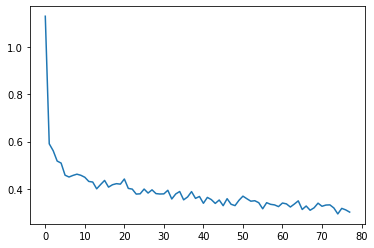

In [14]:
# Plot loss
plt.plot(tabnet_clf.history['loss'])

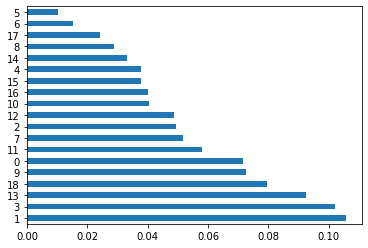

In [17]:
# find and plot feature importance
y_pred = tabnet_clf.predict(X_test)
tabnet_clf.feature_importances_
feat_importances = pd.Series(tabnet_clf.feature_importances_)
feat_importances.nlargest(20).plot(kind='barh')

In [19]:
# determine best accuracy for test set
preds = tabnet_clf.predict(X_test)
test_acc = accuracy_score(preds, y_test)

In [21]:
# determine best accuracy for test set
preds_valid = tabnet_clf.predict(X_test)
valid_acc = accuracy_score(preds_valid, y_test)

In [22]:
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")

BEST ACCURACY SCORE ON VALIDATION SET : 0.8205128205128205
BEST ACCURACY SCORE ON TEST SET : 0.8205128205128205
